# Import Library

Import library yang dibutuhkan.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# Load Dataset

Dataset yang digunakan : [Crop Recommendation Dataset](https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset)

In [2]:
# Load dataset dan menampilkan nya

df = pd.read_csv("../Dataset/crop_recommendation.csv")
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


# EDA

In [3]:
# Melihat informasi data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [4]:
# Memisahkan antara fitur kategorikal dan numerikal

categorical = ['label']
numericals = df.drop(columns = categorical, axis = 1).columns

In [5]:
# Melihat deskripsi fitur numerikal

df[numericals].describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


## Error Value

Mengecek apakah ada nilai null atau kosong pada dataset kita.

In [6]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [7]:
# Menghitung value error pada fitur numerikal (minus)

for i in (df[numericals]):
  misValue = (df[i] < 0).sum()
  print(f'Value error pada {i} :', misValue)

Value error pada N : 0
Value error pada P : 0
Value error pada K : 0
Value error pada temperature : 0
Value error pada humidity : 0
Value error pada ph : 0
Value error pada rainfall : 0


Dataset yang kita gunakan merupakan dataset yang bersih, sehingga kita tidak perlu melakukan cleaning pada dataset.

## Distribusi Data

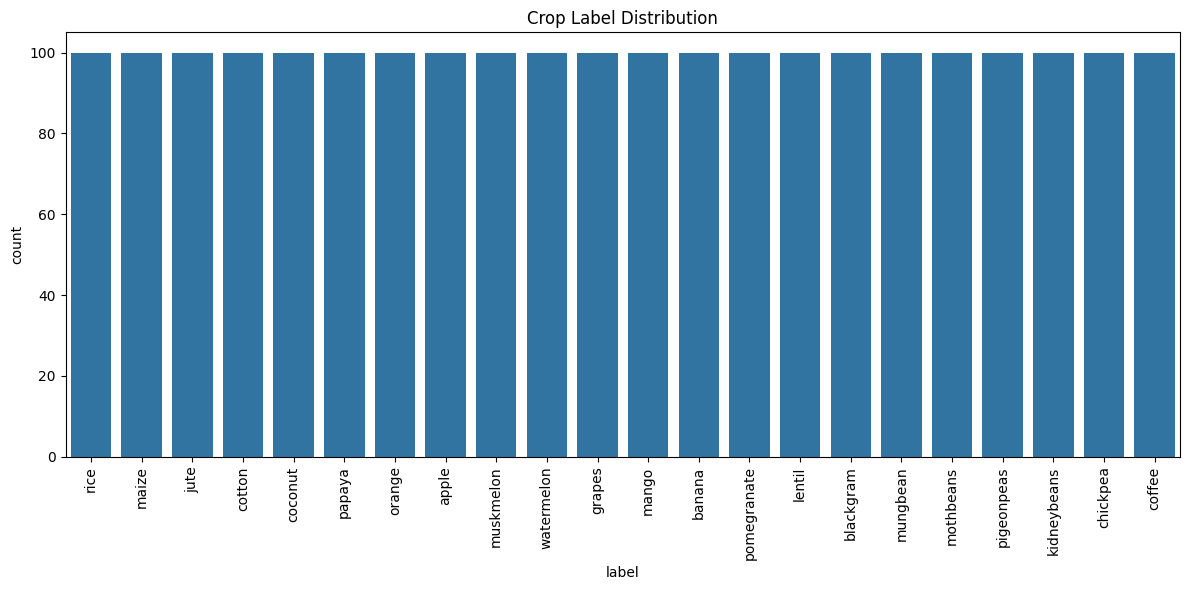

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Crop Label Distribution')
plt.tight_layout()
plt.show()

Pada visualisasi distribusi `label` diatas, setiap label memiliki data sebanyak 100 data yang dimana distribusi tiap `label` seimbang.

## Check for outliers

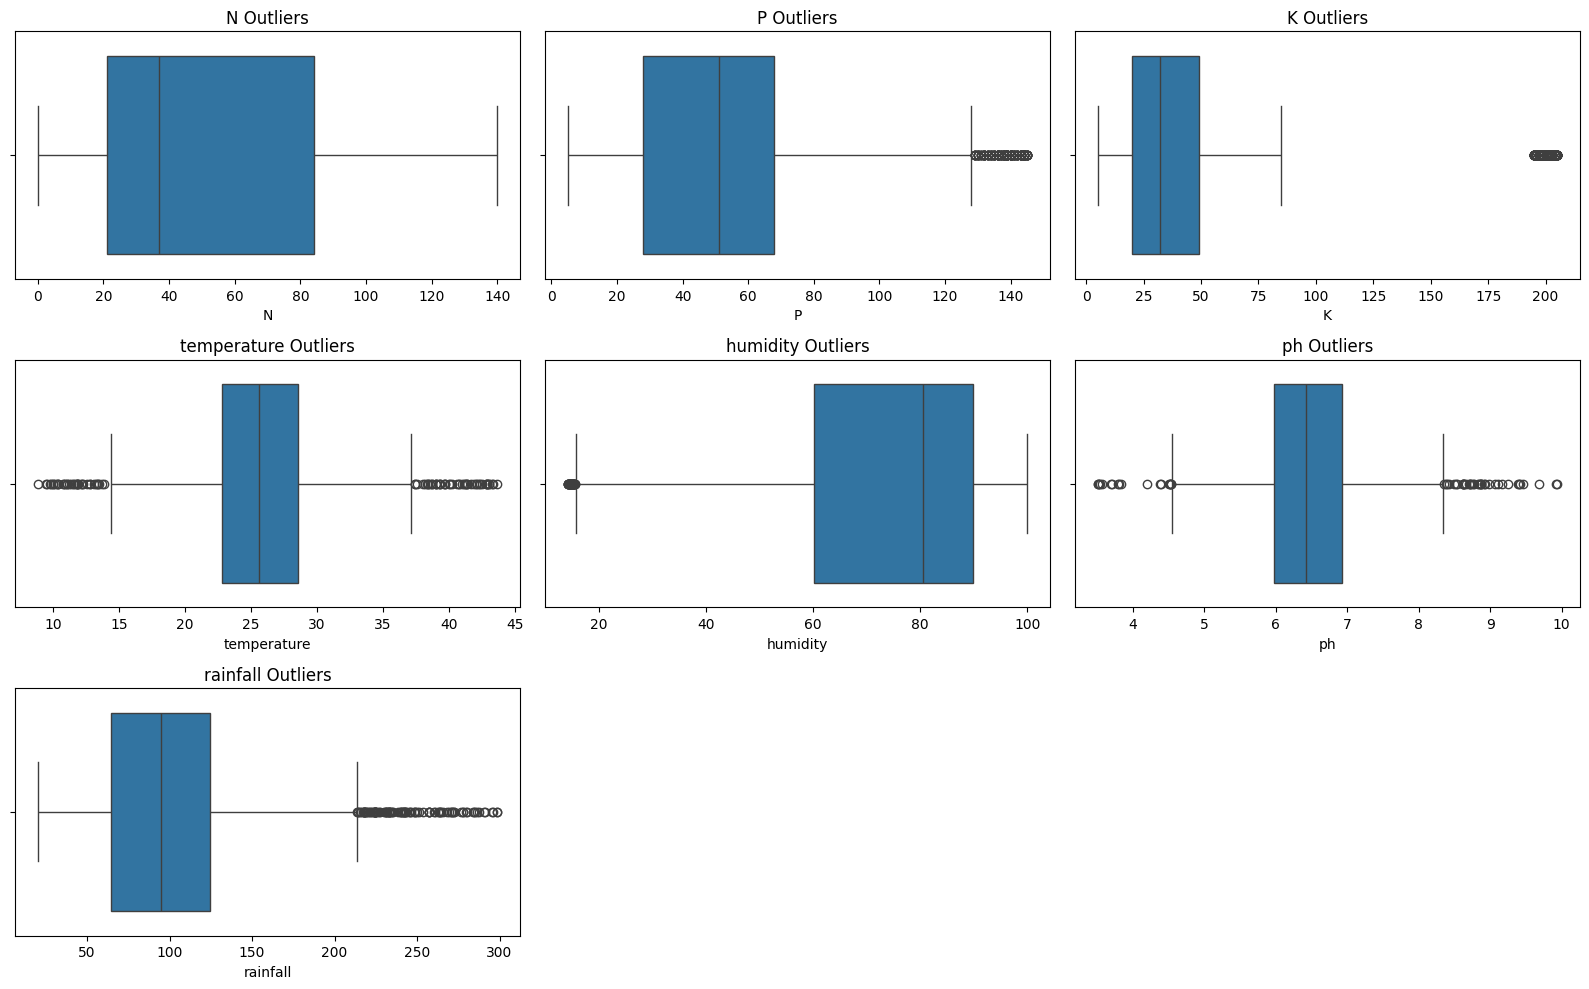

In [9]:
plt.figure(figsize=(16, 10))
for i, numerical in enumerate(numericals, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[numerical])
    plt.title(f'{numerical} Outliers')
plt.tight_layout()
plt.show()

### IQR

Karena terdapat nilai yang dapat dikatakan sebagai outliers, maka kita akan mencoba membersihkan nya.

In [10]:
df_clean = df.copy()

In [11]:
for col in numericals:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

In [12]:
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")

Original dataset shape: (2200, 8)
Cleaned dataset shape: (1846, 8)


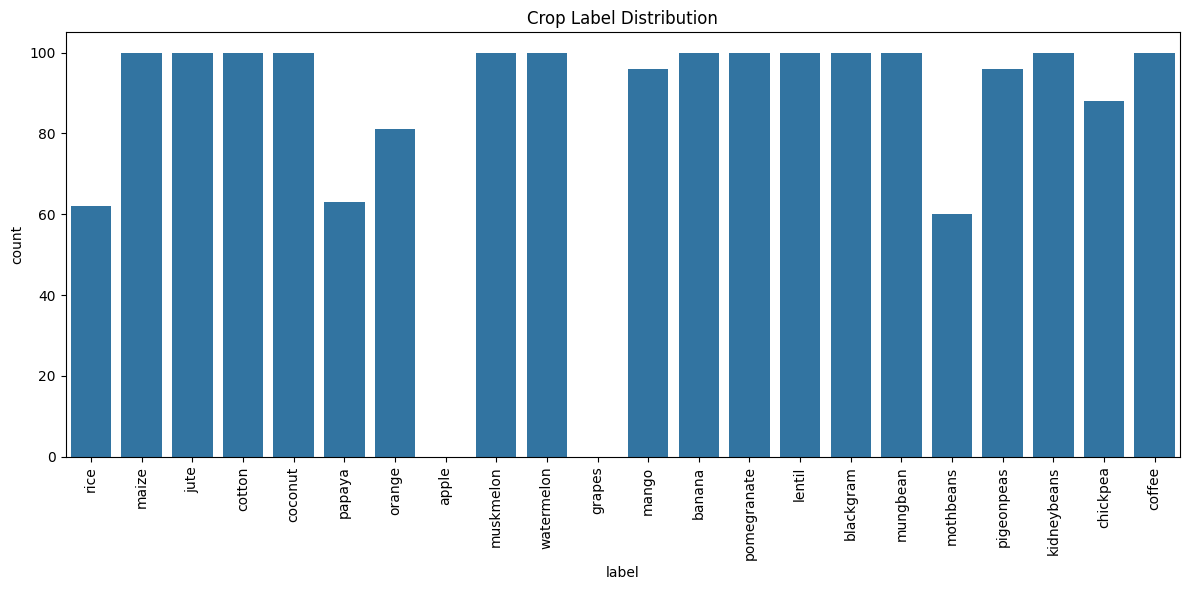

In [13]:
# Melihat distribusi setelah penghapusan outliers

plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Crop Label Distribution')
plt.tight_layout()
plt.show()

Karena percobaan untuk menghapus outliers menggunakan IQR tidak membuahkan hasil yang baik, maka kita akan tetap menggunakan data yang lama

## Univariate Analysis

In [14]:
n_cols = 2
n_rows = (len(numericals) + 1) // n_cols

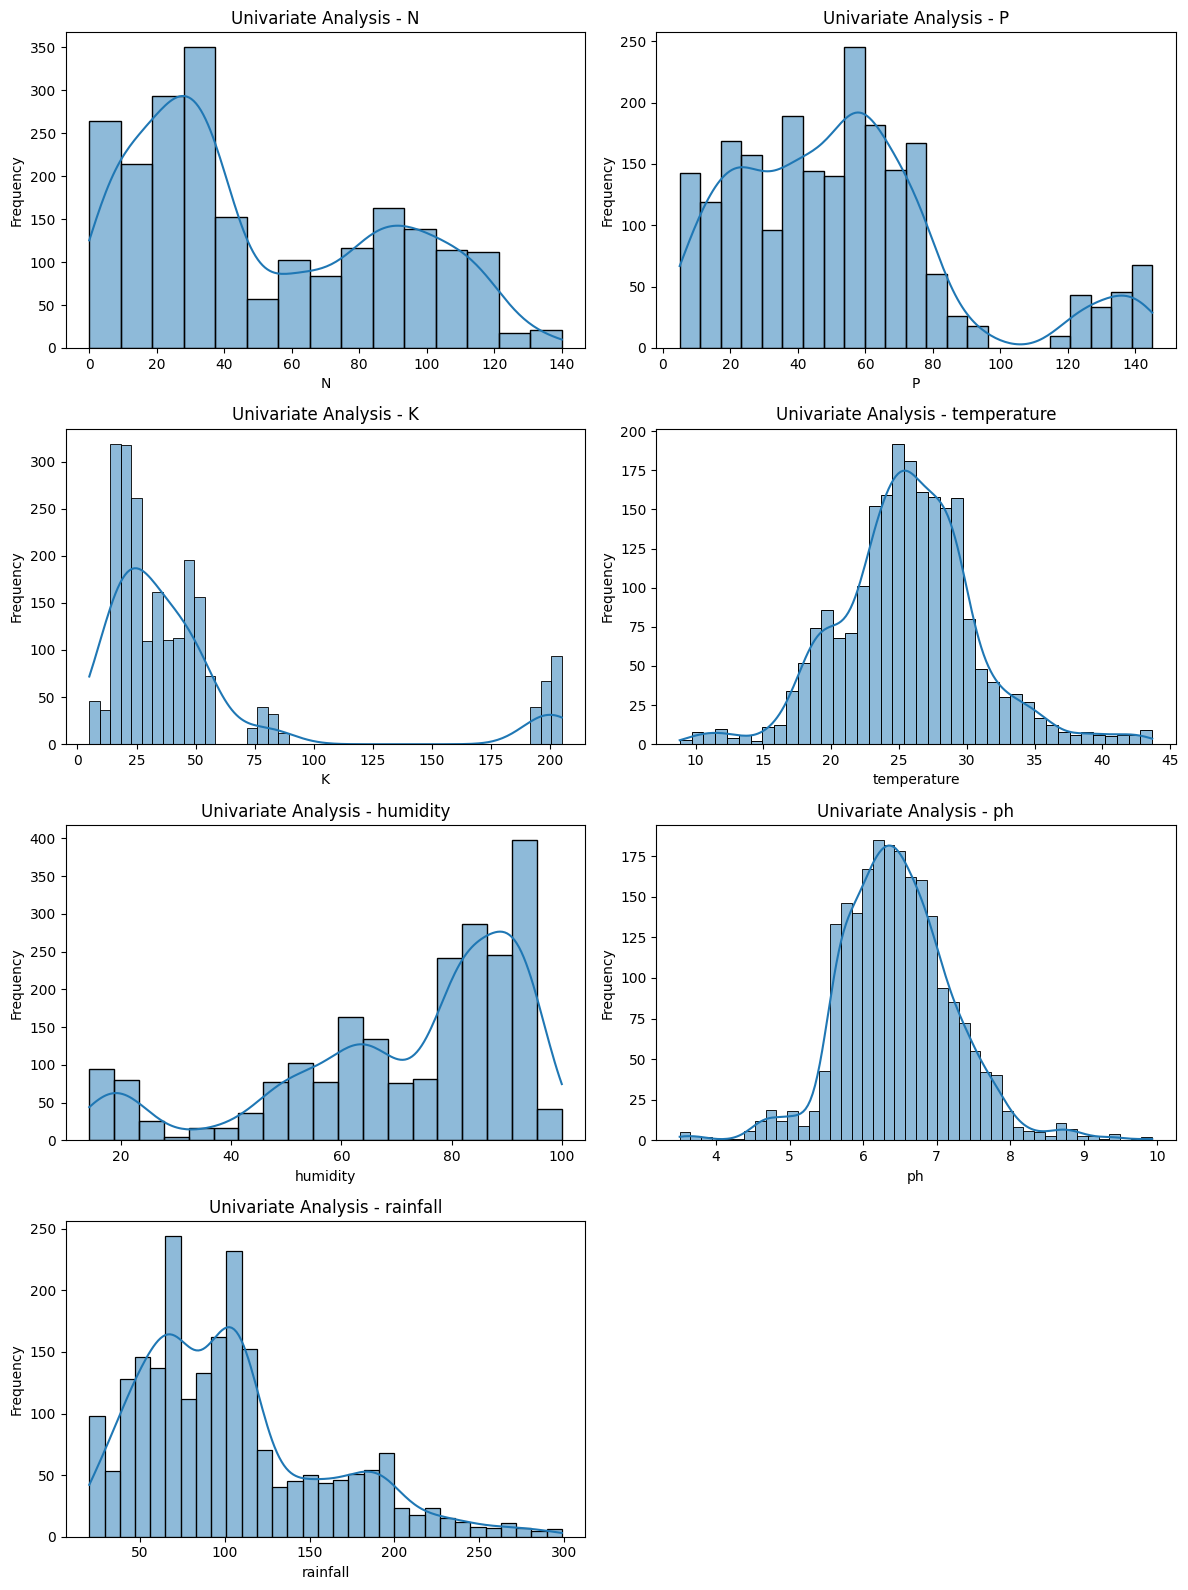

In [15]:
plt.figure(figsize=(12, 4 * n_rows))

for idx, col in enumerate(numericals, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(df[col], kde=True)
    plt.title(f'Univariate Analysis - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Berikut adalah hasil analisa histogram diatas:

- N (**Nitrogen**): Distribusi nitogres condong ke kiri dengan mayoritas nilai berada di bawah 50
- P (**Fosforus**): Distribusi fosforus menyebar lebih merata dengan puncak di nilai sekitar 60 dan terdapat lonjakan pada nilai diatas 120
- K (**Potasium**): Distribusi potasium condong ke kiri dengan mayoritas nilai berada di bawah 50 dan terdapat nilai yang tinggi yaitu pada nilai sekitar 200
- *Temperature* (**Suhu**): Distribusi suhu simetris dan mendekati normal dengan puncak di sekitar 25 derajat celcius.
- *Humidity* (**Kelembaban**): Distribusi kelembaban condong ke kanan dengan sebagian besar data beradara di antara 60% hingga 90%.
- pH (**Keasaman Tanah**): Distribusi pH simetris dan mendekati normal dengan puncak di sekitar pH 6 dan pH 7.
- *Rainfall* (**Curah Hujan**): Distrubsi curah hujan condong ke kiri dengan mayoritas nilai berada di rentang 50mm hingan 150mm

## Multivariate Analysis (Correlation Heatmap + Pairplot)

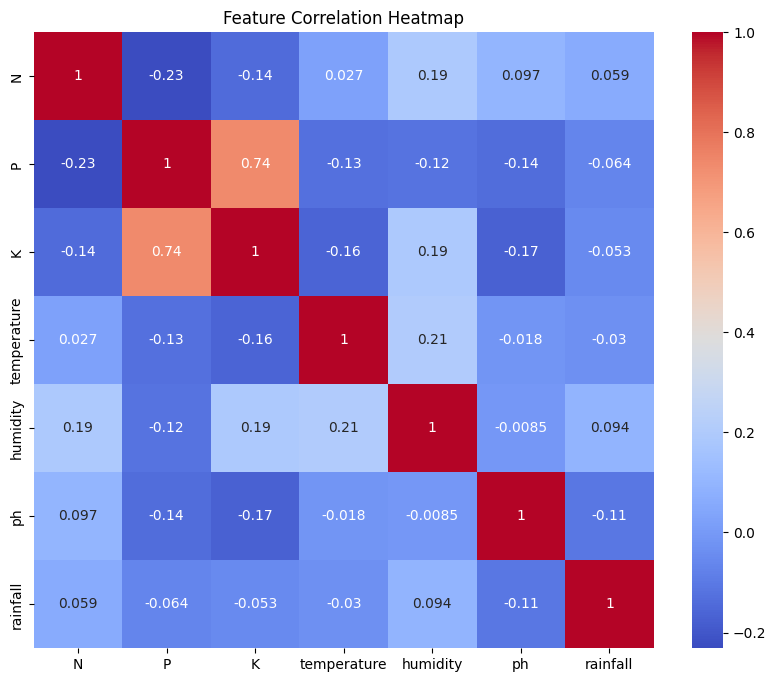

In [16]:
# Menampilkan correlation antar fitur numerikal

plt.figure(figsize=(10, 8))
sns.heatmap(df[numericals].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

Dari nilai korelasi matriks diatas, fitur **K (Potasium)** dan **P (Fosforus)** mendapatkan nilai korelasi terbesar yaitu di angka `0.74`.

# Data Preparation

## Split dataset

Membagi data menjadi train 80% dan test 20%

In [17]:
x = df.iloc[:, :-1]
y = df['label']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [19]:
# Melihat jumlah data

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1760, 7)
(1760,)
(440, 7)
(440,)


## Normalization

Disini kita akan melakukan normalisasi data menggunakan ***MinMaxScaler***

In [20]:
scaler = MinMaxScaler()

x_train[numericals] = scaler.fit_transform(x_train[numericals])
x_test[numericals] = scaler.fit_transform(x_test[numericals])
x_train[numericals].describe().round(4)

,N,P,K,temperature,humidity,ph,rainfall
count,1760.0000,1760.0000,1760.0000,1760.0000,1760.0000,1760.0000,1760.0000
mean,0.3620,0.3458,0.2157,0.4807,0.6684,0.4621,0.2958
std,0.2664,0.2373,0.2554,0.1461,0.2570,0.1203,0.1975
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.1429,0.1643,0.0750,0.3997,0.5368,0.3825,0.1572
50%,0.2643,0.3286,0.1300,0.4812,0.7728,0.4554,0.2658
75%,0.6071,0.4500,0.2150,0.5652,0.8824,0.5323,0.3671
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## Label Encoder

Kita akan merubah data label yang sebelumnya bertipe kategorikal menjadi numerikal terlebih dahulu.

In [21]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.transform(y_train)

# Modeling

Pada percobaan ini, kita akan menggunakan 3 model yang berbeda. Yaitu ***RandomForestClassifier***, ***KNN***, dan ***LogisticRegression***.

## Hyperparameter

Kita akan mencoba mencari parameter terbaik pada masing-masing model menggunakan ***GridSearch***.

In [22]:
KNN = KNeighborsClassifier()
RF = RandomForestClassifier()
LR = LogisticRegression()

In [23]:
def best_param(x, y):
    algorithms = {
        'KNN': {
            'model': KNN,
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },
        'RandomForest': {
            'model': RF,
            'params': {
                'n_estimators': [100, 150],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            }
        },
        'LogisticRegression': {
            'model': LR,
            'params': {
                'C': [0.1, 1.0, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        }
    }

    scores = []
    for algo_name, config in algorithms.items():
        gs = GridSearchCV(config['model'], config['params'], cv=10, n_jobs=-1, scoring='accuracy')
        gs.fit(x, y)
        scores.append({
            'model': algo_name,
            'best_score': round(gs.best_score_, 4),
            'best_params': gs.best_params_
        })
        print(f"{algo_name} - Best Score: {round(gs.best_score_, 4)}")
        print(f"Best Parameters: {gs.best_params_}")
        print("-" * 50)
        print(f"Best Estimator: {gs.best_estimator_}")
        print("=" * 50)
        print("\n")
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [24]:
best_param(x, y)

KNN - Best Score: 0.9836
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
--------------------------------------------------
Best Estimator: KNeighborsClassifier(metric='manhattan')


RandomForest - Best Score: 0.995
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
--------------------------------------------------
Best Estimator: RandomForestClassifier()


LogisticRegression - Best Score: 0.9609
Best Parameters: {'C': 10, 'solver': 'liblinear'}
--------------------------------------------------
Best Estimator: LogisticRegression(C=10, solver='liblinear')




,model,best_score,best_params
0,KNN,0.9836,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei..."
1,RandomForest,0.9950,"{'max_depth': None, 'min_samples_split': 2, 'n..."
2,LogisticRegression,0.9609,"{'C': 10, 'solver': 'liblinear'}"


Pada pencarian **GridSearch**, model ***RandomForest*** mendapatkan akurasi tertinggi pada tahap pencarian parameter yaitu diangka `0.9950`.

# Evaluation

Kita akan mengevaluasi 3 model tersebut menggunakan parameter terbaik yang telah ditentukan menggunakan ***GridSearch***.

In [25]:
# Implementasi parameter terbaik

KNN = KNeighborsClassifier(
    n_neighbors=5,
    metric='manhattan',
    weights='uniform'
)

RF = RandomForestClassifier(
    max_depth=10,
    min_samples_split=2,
    n_estimators=150
)
LR = LogisticRegression(
    C=10,
    solver='liblinear'
)

acc = pd.DataFrame(index = ['accuracy'], columns = ['KNN', 'RandomForest', 'LogisticRegression'])

In [26]:
# Model KNN accuracy
KNN.fit(x_train, y_train_encoded)
acc.loc['accuracy', 'KNN'] = KNN.score(x_test,y_test_encoded)

# Model RandomForest accuracy
RF.fit(x_train, y_train_encoded)
acc.loc['accuracy', 'RandomForest'] = RF.score(x_test,y_test_encoded)

# Model LogisticRegression accuracy
LR.fit(x_train, y_train_encoded)
acc.loc['accuracy', 'LogisticRegression'] = LR.score(x_test,y_test_encoded)

In [27]:
acc

,KNN,RandomForest,LogisticRegression
accuracy,0.970455,0.988636,0.938636


Hasil evaluasi juga menunjukkan model ***RandomForest*** berhasil unggul dari model yang lain. Walau begitu, ***KNN*** dan ***LogisticRegression*** juga menunjukkan akurasi yang tinggi (+0.9).

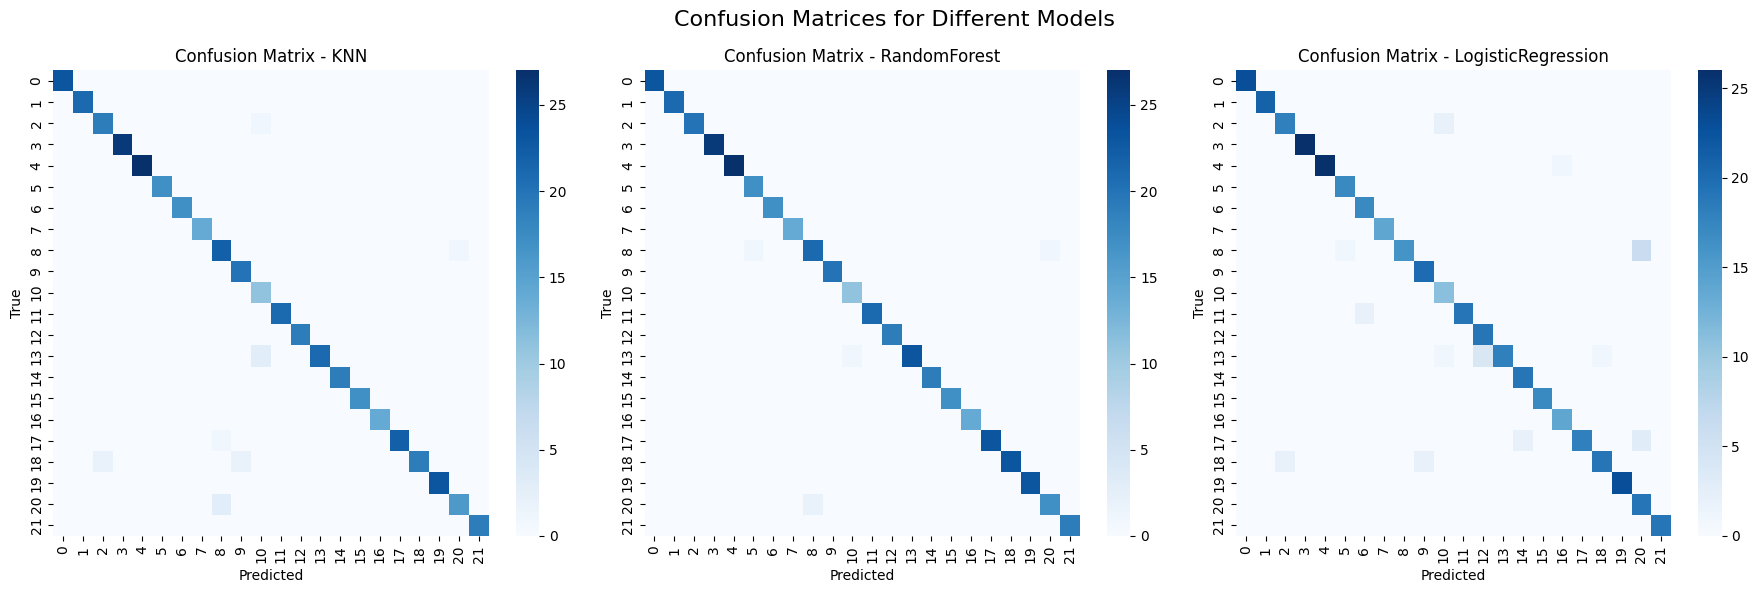


Classification Report - KNN
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       0.90      0.95      0.93        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.85      0.96      0.90        23
 kidneybeans       0.91      1.00      0.95        20
      lentil       0.73      1.00      0.85        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.88      0.93        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        1

In [ ]:
models = {
    'KNN': KNN,
    'RandomForest': RF,
    'LogisticRegression': LR
}

# Membuat plot confusion matrix untuk tiap model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, model) in enumerate(models.items()):
    # Mendapatkan hasil prediksi
    y_pred = model.predict(x_test)
    
    # Menghitung confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    
    # Menampilkan confusion matrix
    sns.heatmap(cm, cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.suptitle('Confusion Matrices for Different Models', fontsize=16)
plt.tight_layout()
plt.show()

# Print classification reports
for name, model in models.items():
    y_pred = model.predict(x_test)
    print(f"\nClassification Report - {name}")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Kesimpulan

Pelatihan yang telah kita lakukan pada proyek ini menunjukkan bahwa ***RandomForest*** memiliki akurasi tertinggi, disusul oleh ***KNN*** dan ***LogisticRegression***. Dengan akurasi pada ***RandomForest*** adalah `0.988636`, KNN `0.970455`, dan LogisticRegression `0.938636`. Ketiga model berhasil menunjukkan akurasi yang cukup tinggi yaitu diatas `0.9`, yang mengindikasikan bahwa data telah berhasil diproses dengan baik, serta proses tuning parameter menggunakan ***GridSearch*** memberikan hasil yang optimal bagi masing-masing model.

Begitu juga dari hasil visualisasi ***Confusion Matrix***, yang menunjukkan bahwa model mampu melakukan prediksi dengan tingkat kesalahan yang rendah, baik pada data latih maupun data uji. Hal ini terlihat dari banyaknya prediksi yang berada pada diagonal utama, yang menandakan bahwa sebagian besar data berhasil diklasifikasikan dengan benar.